<a href="https://colab.research.google.com/github/Bensayah/fuzzy-c-means/blob/master/numerical_approximation__sir_model_two_methods_classic_and_ann.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Numerical simulation of the results obtained in the paper:
### Analytical and numerical  study of a fractal-fractional order mathematical model on the spread of Coronavirus (COVID-19)

---



 **Authors:** Hashem Najafi, Abdallah Bensayah, Brahim Tellab, Sina Etemad, Sotiris K. Ntouyas,
Shahram Rezapour, and Jessada Tariboon

 **Address:** Laboratoire de Mathématiques Appliquées, Université Kasdi Merbah, BP511, Ouargla, 30000, Algeria

 **Github address:** https://github.com/Bensayah/RIS-models.git

# **First method**: Adams-Bashforth fractional approximation method

In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import scipy as sc
from scipy import interpolate
from scipy.special import gamma
from scipy.integrate import quad
from math import pi, sqrt
from scipy.optimize import fsolve
%matplotlib inline
from matplotlib.pylab import *
## check if GPU is available and use it; otherwise use CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [ ]:
mu = 0.15; beta = 0.55; alpha = 0.45; gamm = 0.25 # constants
S_0 = 80; I_0 = 40; R_0 = 20 # initial cdts
# right hand side functions
G1 = lambda S,I,R: mu*(S+I+R) - beta*((S*I)/(1+alpha*I)) - mu*S
G2 = lambda S,I,R: beta*((S*I)/(1+alpha*I)) - (gamm+mu)*I
G3 = lambda S,I,R: gamm*I - mu*R
# definitions of parameters interval [0,T]
T=50
N=1000
h=T/N
p=0.8;q=0.8
X = np.arange(0, T, h).reshape(N,1)
c = p/gamma(q)
# Approximations of integrals
def II(p,q,n,m):
  return quad(lambda s: (s**(p-1))*((X[n]-s)**(q-1))*(s-X[m]),X[m],X[m+1])[0]
def J(p,q,n,m):
  return quad(lambda s: (s**(p-1))*((X[n]-s)**(q-1))*(s-X[m+1]),X[m],X[m+1])[0]
# matrix kernel
def Matrix_kernal(T,N,p,q,II,J,c):
    Ch = np.zeros([N,N])
    for i in range(N):
       for j in range(N):
          if j==0:
            if i==0:
              Ch[i,j]=1
            else:
              Ch[i,j]= -c*(1/h)*J(p,q,i,0)
          elif 0<j<i:
            Ch[i,j]= c*(1/h)*(II(p,q,i,j-1)-J(p,q,i,j))
          else: Ch[i,j]=0
    for i in range(1,N):
        Ch[i,i]= c*(1/h)*II(p,q,i,i-1)
    return Ch

In [ ]:
B=Matrix_kernal(T,N,p,q,II,J,c)[1:N,0:N]

In [ ]:
def sol(k,G_1,G_2,G_3):# k= 1,2,...,N
    #B=Matrix_kernal(T,N,p,q,I,J,c)[1:N,0:N]
    def eqs(vars):
       x1,x2,x3= vars
       eq1= -x1+S_0+ c*(1/h)*II(p,q,k,k-1)*G1(x1,x2,x3)+np.dot(B[k-1,:],G_1)
       eq2= -x2+I_0+ c*(1/h)*II(p,q,k,k-1)*G2(x1,x2,x3)+np.dot(B[k-1,:],G_2)
       eq3= -x3+R_0+ c*(1/h)*II(p,q,k,k-1)*G3(x1,x2,x3)+np.dot(B[k-1,:],G_3)

       return [eq1, eq2,eq3]
    x, y,z =  fsolve(eqs, (S_0,I_0,R_0))
    return np.array([x]),np.array([y]),np.array([z])

In [ ]:
def Solve(N,S_0,I_0,R_0):
  S= np.zeros(N);I= np.zeros(N);R= np.zeros(N)
  S[0] = S_0;I[0] = I_0; R[0] = R_0
  G_1= np.zeros(N);G_2= np.zeros(N);G_3= np.zeros(N)
  G_1[0]=G1(S_0,I_0,R_0);G_2[0]=G2(S_0,I_0,R_0);G_3[0]=G3(S_0,I_0,R_0)
  for i in range(1,N):
    S[i]=sol(i,G_1,G_2,G_3)[0]
    I[i]=sol(i,G_1,G_2,G_3)[1]
    R[i]=sol(i,G_1,G_2,G_3)[2]
    G_1[i]=G1(S[i],I[i],R[i])
    G_2[i]=G2(S[i],I[i],R[i])
    G_3[i]=G3(S[i],I[i],R[i])

  return S,I,R

In [ ]:
S,I,R=Solve(N,S_0,I_0,R_0)

Text(0.5, 1.0, '$\\nu=\\rho=0.8$')

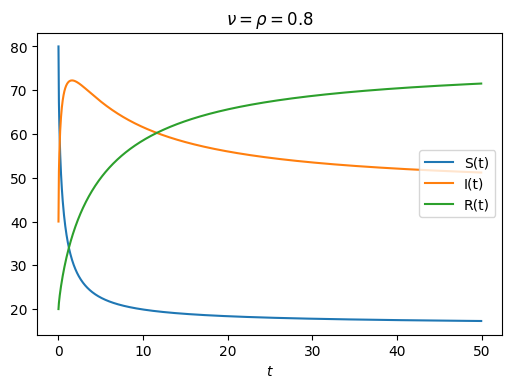

In [ ]:
plt.rcParams["figure.figsize"] = [6,4]

fig, ax = plt.subplots(dpi=100)
ax.plot(X, S,label='S(t)')
ax.plot(X, I,label='I(t)')
ax.plot(X, R,label='R(t)')
ax.set_xlabel('$t$')
ax.set_ylabel('')
plt.legend(loc='right')
plt.title(r'$\nu=\rho=0.8$')

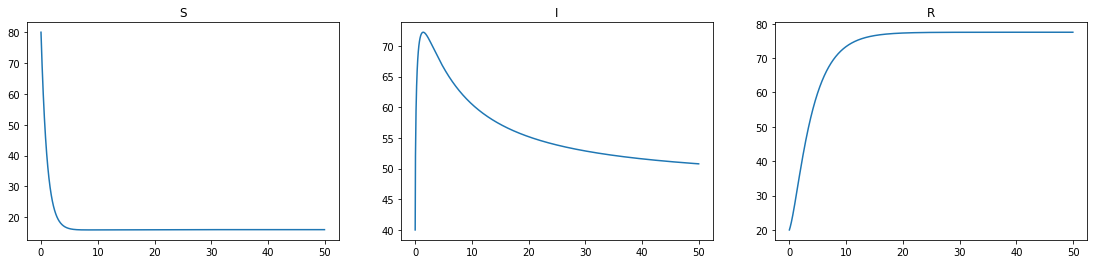

In [ ]:
plt.rcParams["figure.figsize"] = [19,4]

plt.subplot(1,3,1)
plt.plot(X, S)
plt.title('S')

plt.subplot(1,3,2)
plt.plot(X, I)
plt.title('I')

plt.subplot(1,3,3)
plt.plot(X, R)
plt.title('R')


plt.show()


## The case p,q different


In [ ]:
# The case p,q different
P=[1,0.82,0.86,0.95,1]
Q=[0.88,0.81,0.83,0.91,0.98]
Sp= np.zeros([N,5])
Ip= np.zeros([N,5])
Rp= np.zeros([N,5])

for i in range(5):
  p=P[i]
  q=Q[i]
  B=Matrix_kernal(T,N,p,q,II,J,c)[1:N,0:N]
  S,I,R=Solve(N,S_0,I_0,R_0)
  Sp[:,i]=S
  Ip[:,i]=I
  Rp[:,i]=R

Text(0.5, 1.0, '$\\nu=1,\\rho=0.88$')

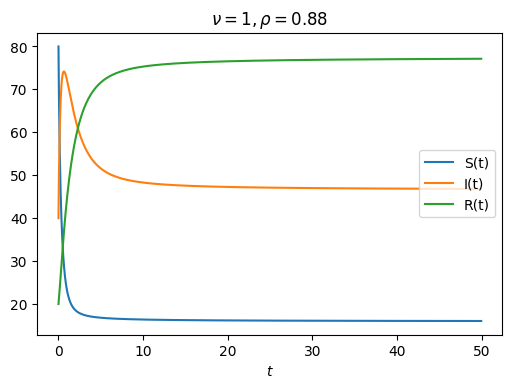

In [ ]:
plt.rcParams["figure.figsize"] = [6,4]

fig, ax = plt.subplots(dpi=100)
ax.plot(X, Sp[:,0],label='S(t)')
ax.plot(X, Ip[:,0],label='I(t)')
ax.plot(X, Rp[:,0],label='R(t)')
ax.set_xlabel('$t$')
ax.set_ylabel('')
plt.legend(loc='right')
plt.title(r'$\nu=1,\rho=0.88$')

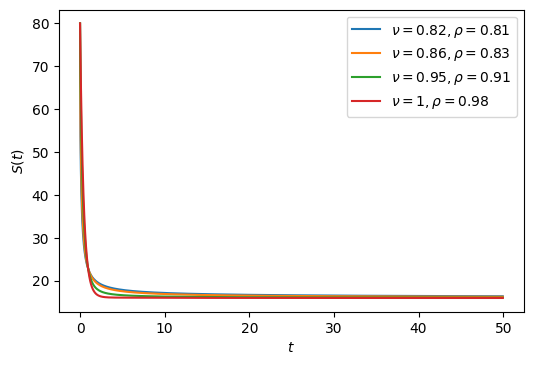

In [ ]:
plt.rcParams["figure.figsize"] = [6,4]

fig, ax = plt.subplots(dpi=100)
ax.plot(X, Sp[:,1],label=r'$\nu=0.82,\rho=0.81$')
ax.plot(X, Sp[:,2],label=r'$\nu=0.86,\rho=0.83$')
ax.plot(X, Sp[:,3],label=r'$\nu=0.95,\rho=0.91$')
ax.plot(X, Sp[:,4],label=r'$\nu=1,\rho=0.98$')

ax.set_xlabel(r'$t$')
ax.set_ylabel('$S(t)$')
plt.legend(loc='best')

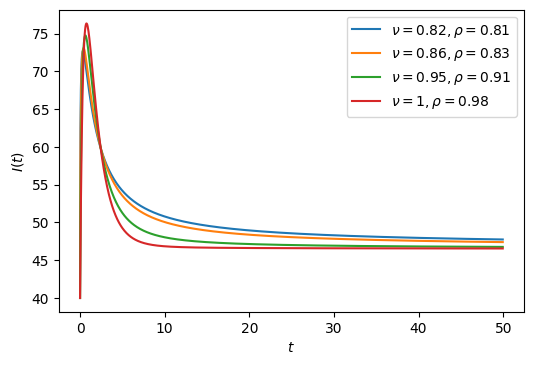

In [ ]:
plt.rcParams["figure.figsize"] = [6,4]

fig, ax = plt.subplots(dpi=100)
ax.plot(X, Ip[:,1],label=r'$\nu=0.82,\rho=0.81$')
ax.plot(X, Ip[:,2],label=r'$\nu=0.86,\rho=0.83$')
ax.plot(X, Ip[:,3],label=r'$\nu=0.95,\rho=0.91$')
ax.plot(X, Ip[:,4],label=r'$\nu=1,\rho=0.98$')
ax.set_xlabel('$t$')
ax.set_ylabel('$I(t)$')
plt.legend(loc='best')

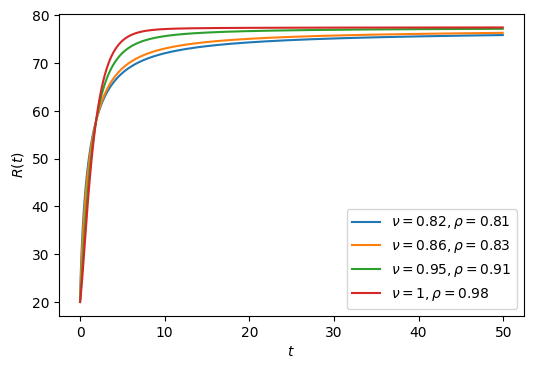

In [ ]:
plt.rcParams["figure.figsize"] = [6,4]

fig, ax = plt.subplots(dpi=100)
ax.plot(X, Rp[:,1],label=r'$\nu=0.82,\rho=0.81$')
ax.plot(X, Rp[:,2],label=r'$\nu=0.86,\rho=0.83$')
ax.plot(X, Rp[:,3],label=r'$\nu=0.95,\rho=0.91$')
ax.plot(X, Rp[:,4],label=r'$\nu=1,\rho=0.98$')
ax.set_xlabel('$t$')
ax.set_ylabel('$R(t)$')
plt.legend(loc='best')

## The case p=q

In [ ]:
# The case p=q
P=[0.80,0.85,0.90,0.95,1]
#Q=[0.80,0.85,0.90,0.95,1]
Spq= np.zeros([N,5])
Ipq= np.zeros([N,5])
Rpq= np.zeros([N,5])

for i in range(5):
  p=P[i]
  q=p
  B=Matrix_kernal(T,N,p,q,II,J,c)[1:N,0:N]
  S,I,R=Solve(N,S_0,I_0,R_0)
  Spq[:,i]=S
  Ipq[:,i]=I
  Rpq[:,i]=R

Text(0.5, 1.0, '$\\nu=\\rho=0.80$')

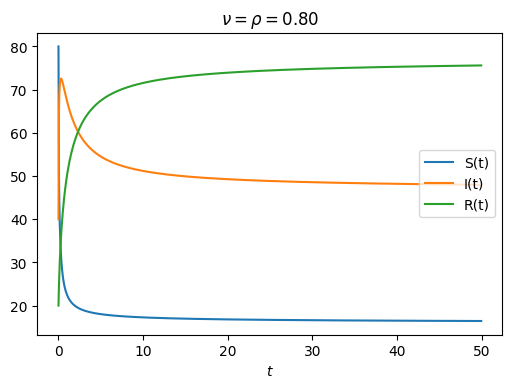

In [ ]:
plt.rcParams["figure.figsize"] = [6,4]

fig, ax = plt.subplots(dpi=100)
ax.plot(X, Spq[:,0],label='S(t)')
ax.plot(X, Ipq[:,0],label='I(t)')
ax.plot(X, Rpq[:,0],label='R(t)')
ax.set_xlabel('$t$')
ax.set_ylabel('')
plt.legend(loc='right')
plt.title(r'$\nu=\rho=0.80$')

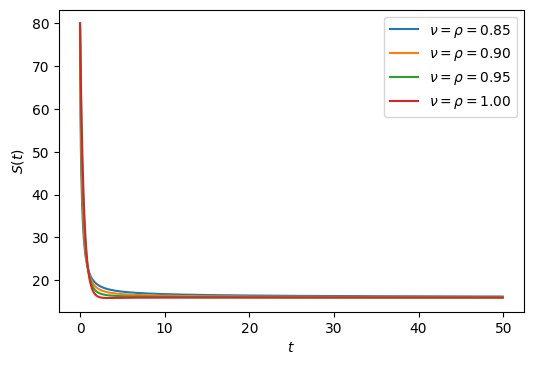

In [ ]:
plt.rcParams["figure.figsize"] = [6,4]

fig, ax = plt.subplots(dpi=100)
ax.plot(X, Spq[:,1],label=r'$\nu=\rho=0.85$')
ax.plot(X, Spq[:,2],label=r'$\nu=\rho=0.90$')
ax.plot(X, Spq[:,3],label=r'$\nu=\rho=0.95$')
ax.plot(X, Spq[:,4],label=r'$\nu=\rho=1.00$')

ax.set_xlabel(r'$t$')
ax.set_ylabel('$S(t)$')
plt.legend(loc='best')

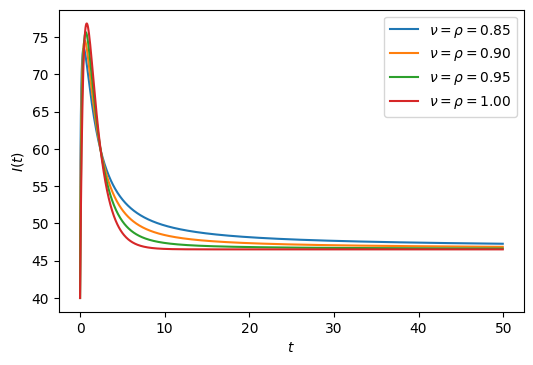

In [ ]:
plt.rcParams["figure.figsize"] = [6,4]

fig, ax = plt.subplots(dpi=100)
ax.plot(X, Ipq[:,1],label=r'$\nu=\rho=0.85$')
ax.plot(X, Ipq[:,2],label=r'$\nu=\rho=0.90$')
ax.plot(X, Ipq[:,3],label=r'$\nu=\rho=0.95$')
ax.plot(X, Ipq[:,4],label=r'$\nu=\rho=1.00$')

ax.set_xlabel(r'$t$')
ax.set_ylabel('$I(t)$')
plt.legend(loc='best')

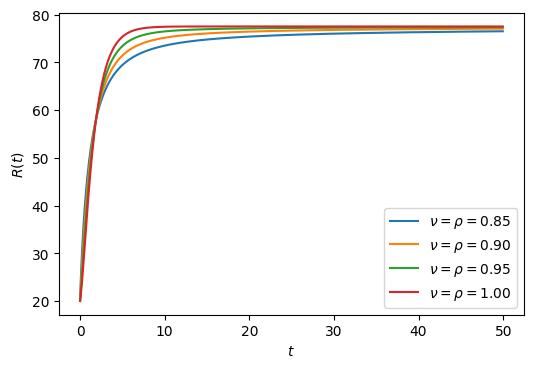

In [ ]:
plt.rcParams["figure.figsize"] = [6,4]

fig, ax = plt.subplots(dpi=100)
ax.plot(X, Rpq[:,1],label=r'$\nu=\rho=0.85$')
ax.plot(X, Rpq[:,2],label=r'$\nu=\rho=0.90$')
ax.plot(X, Rpq[:,3],label=r'$\nu=\rho=0.95$')
ax.plot(X, Rpq[:,4],label=r'$\nu=\rho=1.00$')

ax.set_xlabel(r'$t$')
ax.set_ylabel('$R(t)$')
plt.legend(loc='best')

# **Second method:** Artifical neural network approximation method for SIR system with fractional-fractal kernel vued as Integral Equations System

### Tricked ide.py to handle the kernel:  $s^{(p-1)}(t-s)^{(q-1)}, p,q > 1$.

- add the line:
import scipy as sc
- replace the line:
self.quad_x, self.quad_w = np.polynomial.legendre.leggauss(quad_deg)

> by

> self.quad_x, self.quad_w = sc.special.roots_jacobi(quad_deg,q-1,p-1)

- replace the line: return self.quad_w * x / 2
> by

> return self.quad_w * (x / 2)**(p+q-1)
- declare the function K = 1 i.e.,

> def kernel(x, s):
>>    return 1





          

In [ ]:
!pip install deepxde
import deepxde as dde
import matplotlib.pyplot as plt
import numpy as np
from deepxde.backend import tf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Compiling model...
Building feed-forward neural network...
'build' took 0.179414 s



/usr/local/lib/python3.8/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:103: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 4.090332 s

Initializing variables...
Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [6.50e+01, 1.56e+01, 3.68e+00, 6.35e+01, 1.59e+03, 3.87e+02]    [6.50e+01, 1.56e+01, 3.68e+00, 0.00e+00, 0.00e+00, 0.00e+00]    []  
1000      [1.61e+01, 5.48e+00, 2.22e+01, 5.33e+01, 4.50e+02, 1.22e+01]    [1.61e+01, 5.48e+00, 2.22e+01, 0.00e+00, 0.00e+00, 0.00e+00]    []  
2000      [1.27e+01, 3.58e-01, 5.91e+01, 4.93e+01, 1.15e+02, 5.38e+00]    [1.27e+01, 3.58e-01, 5.91e+01, 0.00e+00, 0.00e+00, 0.00e+00]    []  
3000      [1.14e+01, 2.52e+00, 4.07e+01, 4.37e+01, 3.61e+01, 6.58e+00]    [1.14e+01, 2.52e+00, 4.07e+01, 0.00e+00, 0.00e+00, 0.00e+00]    []  
4000      [1.13e+01, 1.28e+01, 1.48e+01, 2.30e+01, 5.38e-01, 1.22e-01]    [1.13e+01, 1.28e+01, 1.48e+01, 0.00e+00, 0.00e+00, 0.00e+00]    []  
5000      [1.10e+01, 1.23e+01, 9.58e+00, 1.34e+01, 7.43e-03, 4.

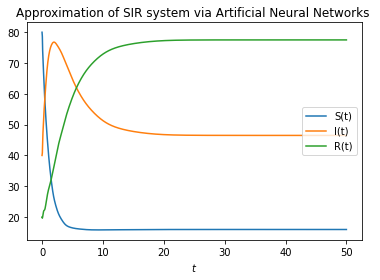

In [ ]:
"""Backend supported: tensorflow.compat.v1"""
import deepxde as dde
import matplotlib.pyplot as plt
import numpy as np
import scipy as sc

from deepxde.backend import tf
from scipy.special import gamma

# constants
mu = 0.15; beta = 0.55; alpha = 0.45; gamm = 0.25 # constants
S_0 = 80; I_0 = 40; R_0 = 20 # initial cdts
# right hand side functions
G1 = lambda S,I,R: mu*(S+I+R) - beta*((S*I)/(1+alpha*I)) - mu*S
G2 = lambda S,I,R: beta*((S*I)/(1+alpha*I)) - (gamm+mu)*I
G3 = lambda S,I,R: gamm*I - mu*R
# definitions of parameters interval [0,T]
T=50
N=1000
h=T/N
p=0.8;q=0.8
X = np.arange(0, T, h).reshape(N,1)
c = p/gamma(q)
def ide(x, y, int_mat):
    y1=y[:,0:1]
    y2=y[:,1:2]
    y3=y[:,2:3]
    rhs1 = tf.matmul(int_mat, G1(y1,y2,y3))
    rhs2 = tf.matmul(int_mat, G2(y1,y2,y3))
    rhs3 = tf.matmul(int_mat, G3(y1,y2,y3))
    eq1 = y1[: tf.size(rhs1)] - S_0 - c*rhs1
    eq2 = y2[: tf.size(rhs2)] - I_0 - c*rhs2
    eq3 = y3[: tf.size(rhs3)] - R_0 - c*rhs3

    return [eq1,eq2,eq3]

def kernel(x, s):
    return 1
#def boundary(_, on_initial):
#    return on_initial
def boundary(x, on_initial):
    return on_initial and np.isclose(x[0], 0)
def func(x):
    return np.exp(-x) * np.cosh(x)


geom = dde.geometry.TimeDomain(0, 50)
#ic = dde.icbc.IC(geom, lambda x: 1, boundary, component=0)

#ic = dde.icbc.IC(geom,func, lambda _, on_initial: on_initial)
#ic1 = dde.icbc.IC(geom, lambda x: 1000, boundary, component=0)
#ic2 = dde.icbc.IC(geom, lambda x: 0.001, boundary, component=1)
ic1 = dde.icbc.IC(geom, lambda x: S_0, boundary, component=0)
ic2 = dde.icbc.IC(geom, lambda x: I_0, boundary, component=1)
ic3 = dde.icbc.IC(geom, lambda x: R_0, boundary, component=2)

quad_deg = 20
data = dde.data.IDE(
    geom,
    ide,
    #ic,
    [ic1,ic2,ic3],
    quad_deg,
    kernel=kernel,
    num_domain=1000,
    num_boundary=2,
    train_distribution="uniform",
    num_test=None
)

layer_size = [1] + [20] * 3 + [3]
activation = "sigmoid"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)

model = dde.Model(data, net)

model.compile("adam", lr=0.001,loss_weights=[0.01,0.01,0.01, 0.01,1, 1])
losshistory, train_state = model.train(epochs=30000)

model.compile("L-BFGS",loss_weights=[0.001,0.01,1, 0.01,1, 1])
losshistory, train_state = model.train()
X = geom.uniform_points(1000)
y_true = func(X)
y_pred = model.predict(X)
#print("L2 relative error:", dde.metrics.l2_relative_error(y_true, y_pred))

plt.figure()
#plt.plot(X, y_true, "-")
#plt.plot(X, y_pred, "--")
plt.plot(X, y_pred[:,0],label='S(t)')
plt.plot(X, y_pred[:,1], label='I(t)')
plt.plot(X, y_pred[:,2], label='R(t)')
plt.legend(loc='right')
plt.xlabel('$t$')
plt.title('Approximation of SIR system via Artificial Neural Networks ')
#plt.plot(X,Y1,X,Y2)
plt.show()
#np.savetxt("test.dat", np.hstack((X, y_true, y_pred)))

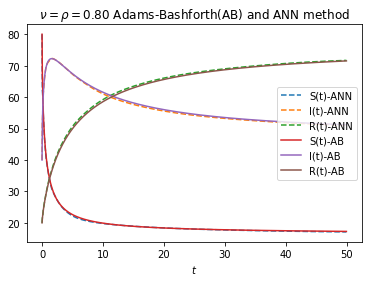

In [ ]:
# graphes of the two approaches in the same figure
plt.figure()
#plt.plot(X, y_true, "-")
#plt.plot(X, y_pred, "--")
plt.plot(X, y_pred[:,0],'--',label='S(t)-ANN')
plt.plot(X, y_pred[:,1],'--', label='I(t)-ANN')
plt.plot(X, y_pred[:,2],'--', label='R(t)-ANN')
plt.plot(X, S,label='S(t)-AB')
plt.plot(X, I,label='I(t)-AB')
plt.plot(X, R,label='R(t)-AB')
plt.xlabel('$t$')
#ax.set_ylabel('')
plt.legend(loc='right')
plt.title(r'$\nu=\rho=0.80$ Adams-Bashforth(AB) and ANN method' )
plt.show()